# Overview

Build a simple deep learning binary classifier using basic features.

In [17]:
import os

import japanize_matplotlib
import keras_tuner as kt
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import tensorflow as tf
import tqdm
from pyspark.sql import SparkSession
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

# At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs,
# please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam

from JapanHorseRaceAnalytics.utilities.base import get_base_dir, read_hive_table

# Set pandas display options
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)

# Set seed for reproducibility
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)
random_state = 42

# Prepare the data

In [2]:
warehouse_dir = f"{get_base_dir()}/spark-warehouse"
postgres_driver_path = f"{get_base_dir()}/jars/postgresql-42.7.1.jar"

spark = (
    SparkSession.builder.appName("20240211_competitors")
    .config("spark.driver.memory", "21g")
    .config("spark.sql.warehouse.dir", warehouse_dir)
    .config("spark.jars", postgres_driver_path)
    .config("spark.executor.extraClassPath", postgres_driver_path)
    .config("spark.driver.extraClassPath", postgres_driver_path)
    .enableHiveSupport()
    .getOrCreate()
)

24/02/23 14:56:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
data = read_hive_table(
    table_name="features_20240217_v1",
    schema="jhra_curated",
    spark_session=spark,
    # use_cache=False,
)

# drop from data where cat_トラック種別 == "障害"
data = data[(data["cat_トラック種別"] != "障害")]

# This would mess up the number of horses in the race
# drop from data where meta_int_race_horses_異常区分 != '0'
# data = data[(data["meta_int_race_horses_異常区分"] == "0")]

data = data.reset_index(drop=True)
data.head()

{"event": "Read from parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_20240217_v1.snappy.parquet to pandas", "level": "info", "timestamp": "2024-02-23T05:56:34.990309Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}


,meta_レースキー,meta_馬番,meta_着順,meta_本賞金,meta_単勝的中,meta_単勝払戻金,meta_複勝的中,meta_複勝払戻金,meta_int_races_レースキー,meta_発走日時,meta_場コード,cat_四半期,cat_距離,cat_事前_馬場状態コード,cat_事前_レース条件_トラック情報_右左,cat_事前_レース条件_トラック情報_内外,cat_事前_レース条件_種別,cat_事前_レース条件_条件,cat_事前_レース条件_記号,cat_事前_レース条件_重量,cat_事前_レース条件_グレード,num_事前_馬場差,cat_実績_馬場状態コード,cat_実績_レース条件_トラック情報_右左,cat_実績_レース条件_トラック情報_内外,cat_実績_レース条件_種別,cat_実績_レース条件_条件,cat_実績_レース条件_記号,cat_実績_レース条件_重量,cat_実績_レース条件_グレード,num_実績_馬場差,num_頭数,cat_トラック種別,cat_馬場状態内,cat_馬場状態中,cat_馬場状態外,num_直線馬場差最内,num_直線馬場差内,num_直線馬場差中,num_直線馬場差外,num_直線馬場差大外,cat_芝種類,cat_草丈,cat_転圧,cat_凍結防止剤,num_中間降水量,meta_int_race_horses_レースキー,meta_int_race_horses_馬番,meta_int_race_horses_血統登録番号,meta_int_race_horses_発走日時,meta_int_race_horses_異常区分,num_事前_ＩＤＭ,cat_事前_脚質,num_事前_単勝オッズ,num_事前_複勝オッズ,cat_事前_馬体,cat_事前_気配コード,cat_事前_上昇度,cat_事前_クラスコード,num_事前_テン指数,num_事前_ペース指数,num_事前_上がり指数,num_実績_ＩＤＭ,cat_実績_脚質,num_実績_単勝オッズ,num_実績_複勝オッズ,cat_実績_馬体,cat_実績_気配コード,cat_実績_上昇度,cat_実績_クラスコード,num_実績_テン指数,num_実績_ペース指数,num_実績_上がり指数,num_負担重量,num_馬体重,num_馬体重増減,cat_性別,cat_トラック種別瞬発戦好走馬,cat_トラック種別消耗戦好走馬,num_一走前不利,num_二走前不利,num_三走前不利,num_一走前着順,num_二走前着順,num_三走前着順,num_四走前着順,num_五走前着順,num_六走前着順,num_騎手指数,num_情報指数,num_オッズ指数,num_パドック指数,num_総合指数,cat_馬具変更情報,cat_脚元情報,cat_見習い区分,cat_オッズ印,cat_パドック印,cat_直前総合印,cat_距離適性,...,num_競争相手平均調教師1位完走,num_競争相手調教師1位完走標準偏差,num_競争相手最高調教師トップ3完走,num_競争相手最低調教師トップ3完走,num_競争相手平均調教師トップ3完走,num_競争相手調教師トップ3完走標準偏差,num_競争相手最高調教師1位完走率,num_競争相手最低調教師1位完走率,num_競争相手平均調教師1位完走率,num_競争相手調教師1位完走率標準偏差,num_競争相手最高調教師トップ3完走率,num_競争相手最低調教師トップ3完走率,num_競争相手平均調教師トップ3完走率,num_競争相手調教師トップ3完走率標準偏差,num_競争相手最高調教師場所レース数,num_競争相手最低調教師場所レース数,num_競争相手平均調教師場所レース数,num_競争相手調教師場所レース数標準偏差,num_競争相手最高調教師場所1位完走,num_競争相手最低調教師場所1位完走,num_競争相手平均調教師場所1位完走,num_競争相手調教師場所1位完走標準偏差,num_競争相手最高調教師場所トップ3完走,num_競争相手最低調教師場所トップ3完走,num_競争相手平均調教師場所トップ3完走,num_競争相手調教師場所トップ3完走標準偏差,num_競争相手最高調教師場所1位完走率,num_競争相手最低調教師場所1位完走率,num_競争相手平均調教師場所1位完走率,num_競争相手調教師場所1位完走率標準偏差,num_競争相手最高調教師場所トップ3完走率,num_競争相手最低調教師場所トップ3完走率,num_競争相手平均調教師場所トップ3完走率,num_競争相手調教師場所トップ3完走率標準偏差,num_競争相手最高調教師本賞金累計,num_競争相手最低調教師本賞金累計,num_競争相手平均調教師本賞金累計,num_競争相手調教師本賞金累計標準偏差,num_競争相手最高調教師1位完走平均賞金,num_競争相手最低調教師1位完走平均賞金,num_競争相手平均調教師1位完走平均賞金,num_競争相手調教師1位完走平均賞金標準偏差,num_競争相手最高調教師レース数平均賞金,num_競争相手最低調教師レース数平均賞金,num_競争相手平均調教師レース数平均賞金,num_競争相手調教師レース数平均賞金標準偏差,num_競争相手平均調教師レース数差,num_競争相手平均調教師1位完走差,num_競争相手平均調教師トップ3完走差,num_競争相手平均調教師1位完走率差,num_競争相手平均調教師トップ3完走率差,num_競争相手平均調教師場所レース数差,num_競争相手平均調教師場所1位完走差,num_競争相手平均調教師場所トップ3完走差,num_競争相手平均調教師場所1位完走率差,num_競争相手平均調教師場所トップ3完走率差,num_競争相手平均調教師本賞金累計差,num_競争相手平均調教師1位完走平均賞金差,num_競争相手平均調教師レース数平均賞金差,meta_int_combinations_レースキー,meta_int_combinations_馬番,num_馬騎手レース数,num_馬騎手1位完走,num_馬騎手1位完走率,num_馬騎手トップ3完走,num_馬騎手トップ3完走率,num_馬騎手初二走,num_馬騎手同騎手,num_馬騎手場所レース数,num_馬騎手場所1位完走,num_馬騎手場所1位完走率,num_馬騎手場所トップ3完走,num_馬騎手場所トップ3完走率,num_馬調教師レース数,num_馬調教師1位完走,num_馬調教師1位完走率,num_馬調教師トップ3完走,num_馬調教師トップ3完走率,num_馬調教師初二走,num_馬調教師同調教師,num_馬調教師場所レース数,num_馬調教師場所1位完走,num_馬調教師場所1位完走率,num_馬調教師場所トップ3完走,num_馬調教師場所トップ3完走率,meta_int_race_weather_レースキー,num_temperature,num_precipitation,num_snowfall,num_snow_depth,num_wind_speed,cat_wind_direction,num_solar_radiation,num_local_air_pressure,num_sea_level_air_pressure,num_relative_humidity,num_vapor_pressure,num_dew_point_temperature,cat_weather,num_visibility
0,01011103,04,6.0,0.0,False,0,False,0,01011103,2001-08-04 01:45:00,01,3,1200,20,1,1,12,A3,102,3,None,NaN,21,1,1,12,A3,102,3,None,-18.0,16,芝,1,1,1,1,1,0,0,0,None,NaN,False,False,NaN,01011103,04,98102049,2001-08-04 01:45:00,0,36.0,好位差し,11.5,2.9,None,None,3,18,-12.4,-21.1,-10.9,31.0,追込,14.8,3.4,普通,2,3,18,-18.9,-30.9,-10.5,550,476.0,14,牡,True,False,NaN,NaN,NaN,7.0,2.0,7.0,NaN,NaN,NaN,0.4,0.4,0.0,1.8,38.6,0,0,0,None,4,4,5,...,34.133333,18.575492,204,32,98.066667,44.395896,0.162376,0.027668,0.075334,0.036725,0.403960,0.120735,0.213261,0.076365,47,3,18.733333,12.390677,8,0,2.066667,2.112397,15,0,4.733333,4.464178,0.333333,0.0,0.094180,0.088041,0.5,0.000000,0.207743,0.136352,231606.0,14187.0,65859.266667,53242.331542,1687.439024,567.857143,913.419366,273.792817,458.625743,49.167979,141.408061,101

In [7]:
spark.stop()

In [4]:
data_ = pd.DataFrame(index=data.index)


# Meta columns
data_["レースキー"] = data["meta_レースキー"]
data_["発走日時"] = data["meta_発走日時"]
data_["馬番"] = data["meta_馬番"]
data_["着順"] = data["meta_着順"]
data_["複勝的中"] = data["meta_複勝的中"].astype(int)
data_["複勝払戻金"] = data["meta_複勝払戻金"]
data_["血統登録番号"] = data["meta_int_race_horses_血統登録番号"]

# Training columns
data_["距離"] = data["cat_距離"]
data_["前走距離差"] = data["num_前走距離差"]
data_["年齢"] = data["num_年齢"]
data_["馬体重"] = data["num_馬体重"]
data_["馬体重増減"] = data["num_馬体重増減"]
data_["負担重量"] = data["num_負担重量"]
data_["頭数"] = data["num_頭数"]
data_["トラック種別"] = data["cat_トラック種別"]
# Impute 着順 with the median
data_["一走前着順"] = data["num_一走前着順"].fillna(data["num_一走前着順"].median())
data_["二走前着順"] = data["num_二走前着順"].fillna(data["num_一走前着順"].median())
data_["三走前着順"] = data["num_三走前着順"].fillna(data["num_一走前着順"].median())
data_["四走前着順"] = data["num_四走前着順"].fillna(data["num_一走前着順"].median())
data_["五走前着順"] = data["num_五走前着順"].fillna(data["num_一走前着順"].median())


# fmt: off
categories = [
    ["距離", [1000, 1150, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 3000, 3200, 3400, 3600]]
]
num_cols = [
    "前走距離差",
    "年齢",
    "馬体重増減",
    "負担重量",
    "頭数",
    "一走前着順",
    "二走前着順",
    "三走前着順",
    "四走前着順",
    "五走前着順",
]
num_null_cols = [
    "馬体重"  # 95% of 馬体重 null values are where 異常区分 != 0
]
cat_cols = [
    "トラック種別"
]
meta_cols = [
    "レースキー",
    "複勝的中",
    "複勝払戻金"
]

category_keys = [c[0] for c in categories] if categories else []
category_values = [c[1] for c in categories] if categories else []
all_cols = category_keys + num_cols + num_null_cols + cat_cols + meta_cols
# fmt: on

preprocessor = ColumnTransformer(
    transformers=[
        # fmt: off
        ("ord", OrdinalEncoder(categories=category_values), category_keys),
        ("num", StandardScaler(), num_cols),
        ("num_null", Pipeline(steps=[("imputer", SimpleImputer()), ("scaler", StandardScaler())]), num_null_cols),
        ("cat", OneHotEncoder(drop="if_binary"), cat_cols),
        # fmt: on
    ],
    remainder="drop",
)

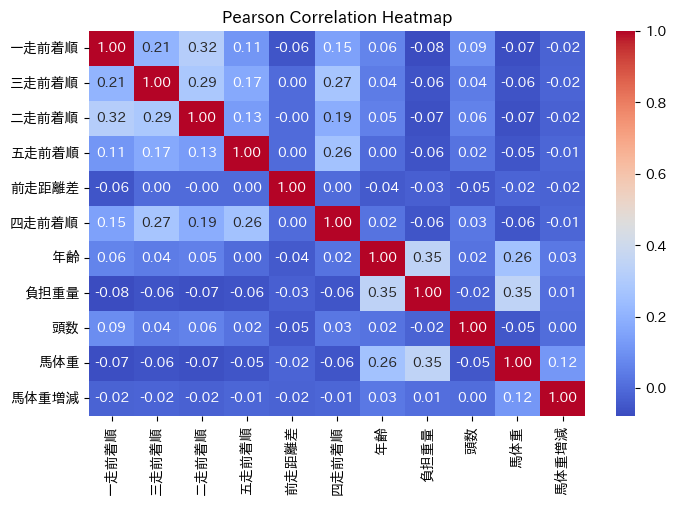

In [8]:
corr = data_[sorted(num_cols + num_null_cols)].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pearson Correlation Heatmap")
plt.show()

# Train/test split

In [9]:
X = data_
y = data_["複勝的中"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

preprocessor.fit(X_train)

X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
print(f"X_train_prep: {X_train_prep.shape}")
print(f"X_test_prep: {X_test_prep.shape}")
print(f"class_weights: {class_weights}")

X_train: (857061, 20)
X_test: (214266, 20)
y_train: (857061,)
y_test: (214266,)
X_train_prep: (857061, 13)
X_test_prep: (214266, 13)
class_weights: {0: 0.6336078032451422, 1: 2.37114819589768}


In [10]:
def get_feature_names(column_transformer: ColumnTransformer):
    output_features = []
    for name, transformer, columns in column_transformer.transformers_:
        if name in ("ord", "num", "num_null"):
            output_features.extend(columns)
        elif name == "cat":
            output_features.extend(transformer.get_feature_names_out(columns))
    return output_features

# Define the model

In [11]:
def build_model(hp):
    n_features = X_train_prep.shape[1]
    model = Sequential()
    model.add(
        Dense(
            units=hp.Int("units1", min_value=32, max_value=512, step=32),
            activation="relu",
            input_shape=(n_features,),
        )
    )
    model.add(
        Dense(
            units=hp.Int("units2", min_value=32, max_value=512, step=32),
            activation="relu",
        )
    )
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=Adam(
            hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="LOG")
        ),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Instantiate the tuner and perform hypertuning

In [25]:
class MLflowLoggingCallback(Callback):
    def on_train_begin(self, logs=None):
        self.mlflow_run = mlflow.start_run()

    def on_train_end(self, logs=None):
        mlflow.end_run()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        mlflow.log_metrics(logs, step=epoch)

In [26]:
experiment_name = "20240223_deep1"

mlflow.set_experiment(experiment_name)

# https://keras.io/api/keras_tuner/tuners/hyperband/
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=10,
    # Hyperband determines the number of models to train in a bracket by computing
    # 1 + log{factor}{max_epochs} and rounding it up to the nearest integer.
    # ceil(1 + log3(10)) = 4
    factor=3,
    directory="data/hyperband",
    project_name=experiment_name,
)

stop_early = EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

mlflow_logging_callback = MLflowLoggingCallback()

tuner.search(
    X_train_prep,
    y_train,
    # number of times the model will iterate over the entire training dataset
    # we set it to 100 and use early stopping to prevent overfitting
    epochs=10,
    # if you aim to optimize model parameters and architecture during development,
    # prefer using validation_split or a separate validation dataset created from your training data,
    # reserving the X_test and y_test strictly for final model evaluation.
    # validation_data=(X_test_prep, y_test),
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[mlflow_logging_callback, stop_early],
)

Trial 30 Complete [00h 19m 54s]
val_accuracy: 0.7894092202186584

Best val_accuracy So Far: 0.7894675135612488
Total elapsed time: 05h 51m 50s


In [29]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(
    f"""
    The hyperparameter search is complete. The optimal number of units in the first densely-connected
    layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
    is {best_hps.get('learning_rate')}.
    """
)
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is 192 and the optimal learning rate for the optimizer
# is 0.005288494573505621.
best_hps.values


    The hyperparameter search is complete. The optimal number of units in the first densely-connected
    layer is 192 and the optimal learning rate for the optimizer
    is 0.005288494573505621.
    


{'units': 192,
 'learning_rate': 0.005288494573505621,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0023'}

# Train the model
Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

In [33]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_prep, y_train, epochs=50, validation_split=0.2)
val_acc_per_epoch = history.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

Epoch 1/50
  417/21427 [..............................] - ETA: 2:57 - loss: 0.6151 - accuracy: 0.7510

KeyboardInterrupt: 

In [32]:
# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

NameError: name 'history' is not defined

# Evaluate the model

## Create an Explainer

In [34]:
def get_random_sample(arr, sample_size=None):
    if sample_size is None:
        sample_size = len(arr)
    if len(arr) > sample_size:
        sample_indices = np.random.choice(len(arr), size=sample_size, replace=False)
    else:
        sample_indices = np.arange(len(arr))
    return arr[sample_indices]


explainer = shap.DeepExplainer(model, get_random_sample(X_train_prep, sample_size=5000))

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


## Compute SHAP Values

In [38]:
def compute_shap_values(explainer, X_test, batch_size=250):
    shap_values = []
    batches = [(i, i + batch_size) for i in range(0, len(X_test), batch_size)]
    for start, stop in tqdm.tqdm(batches, desc="Calculating SHAP values"):
        shap_values.append(explainer.shap_values(X_test[start:stop])[0])
    result = np.concatenate(shap_values, axis=0)
    return result


X_test_sample = get_random_sample(X_test_prep, sample_size=5000)
shap_values = compute_shap_values(explainer, X_test_sample)

Calculating SHAP values: 100%|██████████| 20/20 [00:39<00:00,  2.00s/it]


## Visualize the SHAP Values

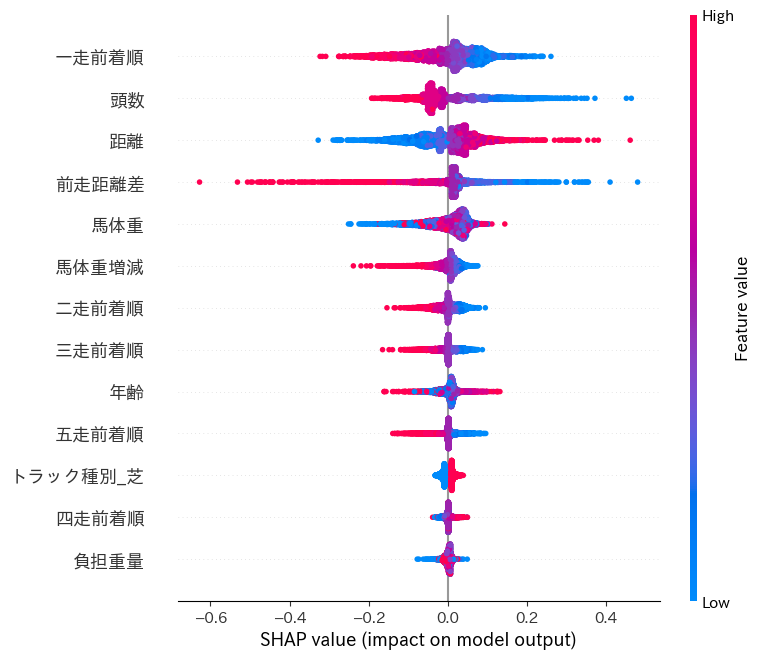

In [39]:
shap.summary_plot(
    shap_values, X_test_sample, feature_names=get_feature_names(preprocessor)
)

In [37]:
# Force Plot (to understand individual predictions)
# For the first prediction
# shap.force_plot(
#     explainer.expected_value[0],
#     shap_values[0][0],
#     X_test_sample[0],
#     feature_names=get_feature_names(preprocessor),
# )

# Assuming explainer is your SHAP explainer object and shap_values have been computed
# And assuming you want to visualize the first sample in X_test_sample

# Correctly accessing the expected value
expected_value = explainer.expected_value

# If explainer.expected_value is a list or array, make sure you are accessing the correct element
if isinstance(expected_value, list) or isinstance(expected_value, np.ndarray):
    expected_value = expected_value[0]  # Adjust this index based on your model's output

# Ensure shap_values and the sample data match in shape and are correctly passed
shap.force_plot(
    expected_value,
    shap_values[0],  # Use [0] if you computed SHAP values for multiple samples and want the first one
    X_test_sample[0],  # Ensure this matches the format expected by SHAP
    feature_names=get_feature_names(preprocessor)  # Assuming this function returns the correct feature names
)


TypeError: Object of type EagerTensor is not JSON serializable

In [40]:
shap.dependence_plot(
    get_feature_names(preprocessor)[0],
    shap_values[0],
    X_test_sample,
    feature_names=get_feature_names(preprocessor),
)

IndexError: index 13 is out of bounds for axis 0 with size 13

In [41]:
y_pred_proba = model.predict(X_test_prep)
y_pred = (y_pred_proba > 0.5).astype(int)
metrics = {
    "loss": log_loss(y_test, y_pred_proba),
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred),
}
print(metrics)

6696/6696 [==============================] - 11s 2ms/step
{'loss': 0.6340963281091986, 'accuracy': 0.7875911250501713, 'precision': 0.34416622269579117, 'recall': 0.01437888129632515, 'f1': 0.027604478249722248, 'roc_auc': 0.5035547197628379}


# Summary